In [1]:

import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms, utils

In [2]:
import numpy as np
import scipy.misc
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import json

In [3]:
def to_grayscale(image):
    """
    input is (d,w,h)
    converts 3D image tensor to grayscale images corresponding to each channel
    """
    image = torch.sum(image, dim=0)
    image = torch.div(image, image.shape[0])
    return image

In [4]:
def normalize(image):
    normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )
    preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
    ])
    image = Variable(preprocess(image).unsqueeze(0).cpu())
    return image


def predict(image):
    _, index = vgg(image).data[0].max(0)
#     print(index)
    
    return str(index[0]), labels[str(index[0])][1]
    
def deprocess(image):
    return image * torch.Tensor([0.229, 0.224, 0.225]).cuda()  + torch.Tensor([0.485, 0.456, 0.406]).cuda()

def load_image(path):
    image = Image.open(path).convert('RGB')
    plt.imshow(image)
    plt.title("Image loaded successfully")
    return image

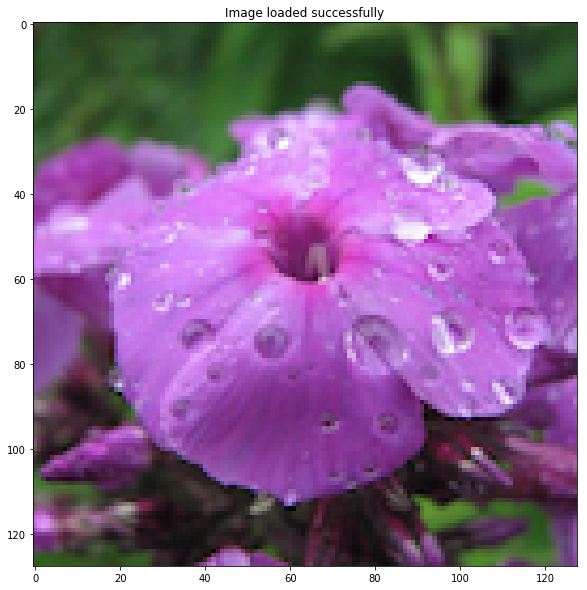

In [23]:
# kitten_1 = load_image("./data/flower/training/aquilegia/0038.png")

kitten_1 = load_image("./data/flower/flower_images/0137.png")



In [6]:
vgg = models.vgg16(pretrained=True)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/cocoslabs/.cache/torch/checkpoints/vgg16-397923af.pth
100.0%


In [24]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [9]:
# labels = json.load(open('labels/imagenet.json'))


In [25]:

kitten_2 = normalize(kitten_1)
# print(predict(kitten_2))

In [26]:
modulelist = list(vgg.features.modules())


In [27]:
def layer_outputs(image):
    outputs = []
    names = []
    for layer in modulelist[1:]:
        image = layer(image)
        outputs.append(image)
        names.append(str(layer))
        
    output_im = []
    for i in outputs:
        i = i.squeeze(0)
        temp = to_grayscale(i)
        output_im.append(temp.data.cpu().numpy())
        
    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (100, 100)


    for i in range(len(output_im)):
        a = fig.add_subplot(len(modulelist), 1 ,i+1)
        imgplot = plt.imshow(output_im[i])
        plt.axis('off')
        a.set_title(names[i].partition('(')[0], fontsize=20)

    plt.savefig('layer_outputs.jpg', bbox_inches='tight')

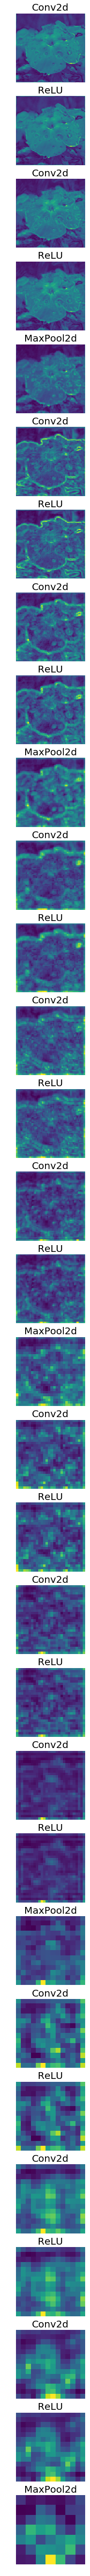

In [29]:
layer_outputs(kitten_2)


In [16]:
def filter_outputs(image, layer_to_visualize):
    if layer_to_visualize < 0:
        layer_to_visualize += 31
    output = None
    name = None
    for count, layer in enumerate(modulelist[1:]):
        image = layer(image)
        if count == layer_to_visualize: 
            output = image
            name = str(layer)
    
    filters = []
    output = output.data.squeeze()
    for i in range(output.shape[0]):
        filters.append(output[i,:,:])
        
    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (10, 10)

    for i in range(int(np.sqrt(len(filters))) * int(np.sqrt(len(filters)))):
        fig.add_subplot(np.sqrt(len(filters)), np.sqrt(len(filters)),i+1)
        imgplot = plt.imshow(filters[i])
        plt.axis('off')
    
#     print(len(filters))
#     print(filters[0].shape)
        
            
#     print(output.shape)

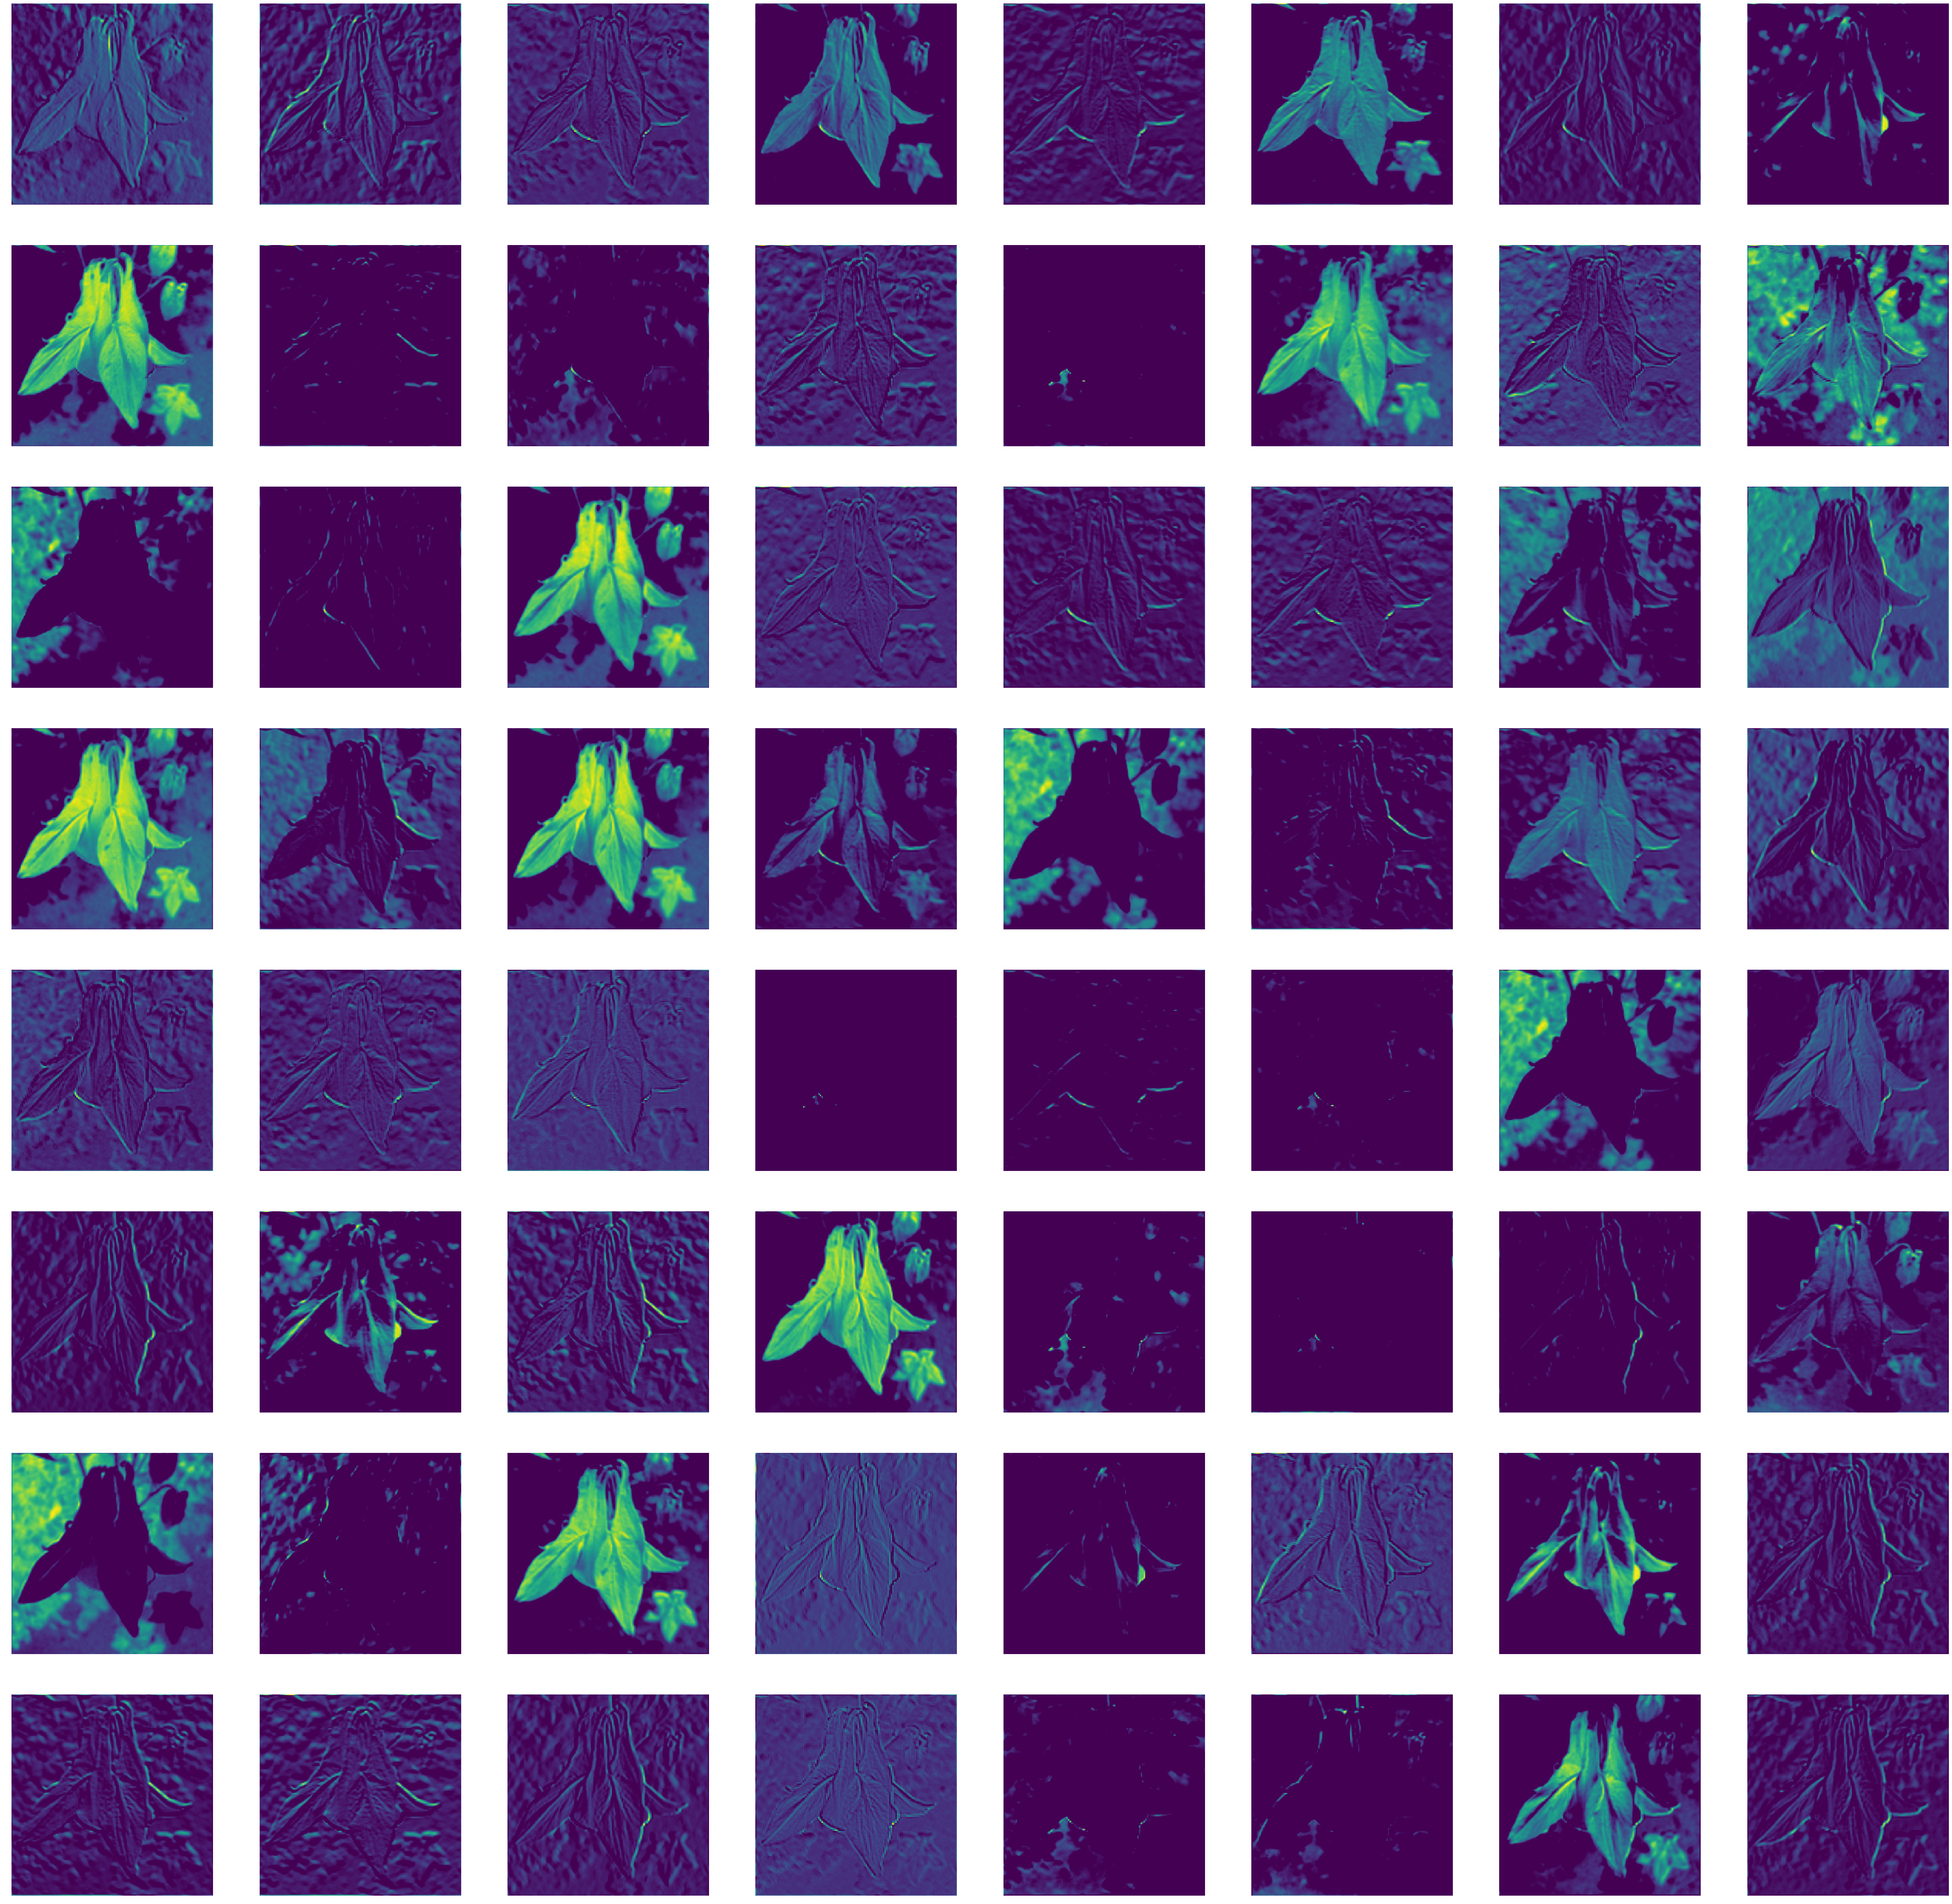

In [17]:
filter_outputs(kitten_2, 0)


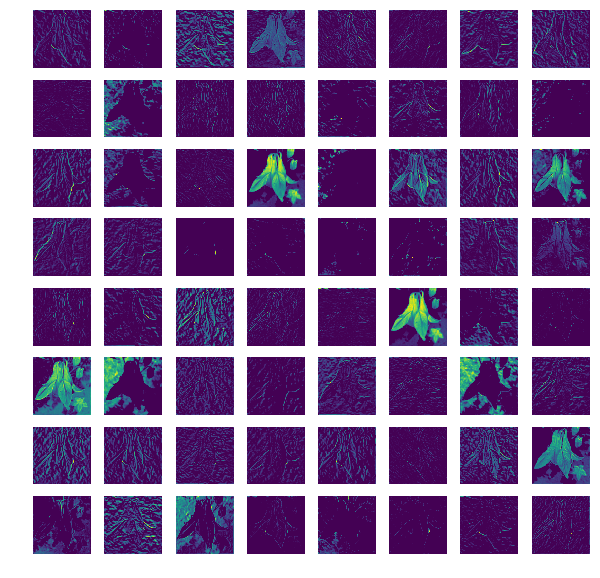

In [18]:
filter_outputs(kitten_2, 3)


In [19]:
def visualize_weights(image, layer):
    weight_used = []
    for w in vgg.features.children():
        if isinstance(w, torch.nn.modules.conv.Conv2d):
            weight_used.append(w.weight.data)

    filters = []
    for i in range(weight_used[layer].shape[0]):
        filters.append(weight_used[layer][i,:,:,:].sum(dim=0))
        filters[i].div(weight_used[layer].shape[1])
        
    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (10, 10)
    for i in range(int(np.sqrt(weight_used[layer].shape[0])) * int(np.sqrt(weight_used[layer].shape[0]))):
        a = fig.add_subplot(np.sqrt(weight_used[layer].shape[0]),np.sqrt(weight_used[layer].shape[0]),i+1)
        imgplot = plt.imshow(filters[i])
        plt.axis('off')
        

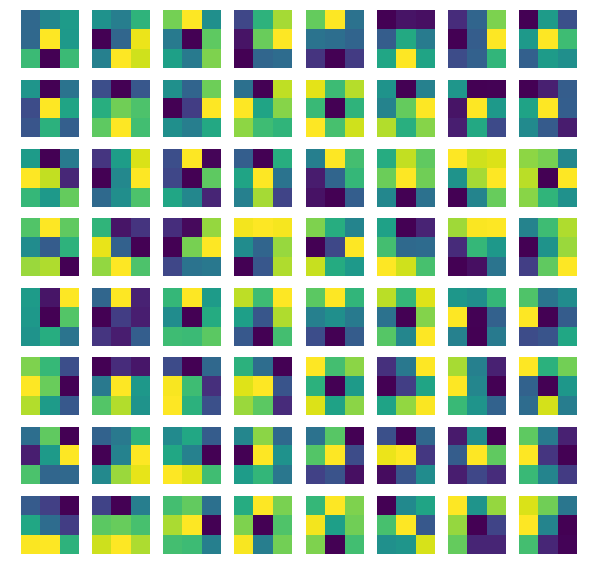

In [20]:

# First conv layer filters
visualize_weights(kitten_2, 0)

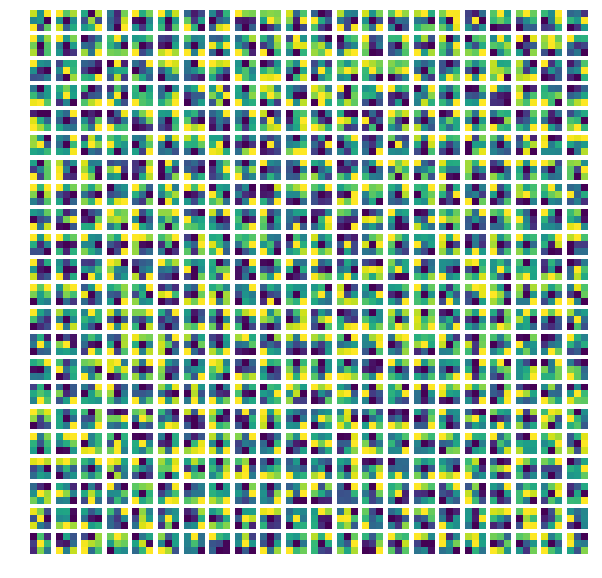

In [21]:

# First conv layer filters
visualize_weights(kitten_2, -1)

In [22]:
def make_heatmap(image, true_class, k=8, stride=8): 
    """
    Input image is of size (1, c, w, h) typically (1, 3, 224, 224) for vgg16
    true_class is a number corresponding to imagenet classes
    k in the filter size (c, k, k)
    """
    heatmap = torch.zeros(int(((image.shape[2]-k)/stride)+1), int(((image.shape[3]-k)/stride)+1))
    image = image.data

    i = 0
    a = 0
    while i<=image.shape[3]-k:
        j = 0 
        b = 0
        while j<=image.shape[2]-k:
            h_filter = torch.ones(image.shape)
            h_filter[:,:,j:j+k, i:i+k] = 0
            temp_image = Variable((image.cpu() * h_filter.cpu()).cpu())
            temp_softmax = vgg(temp_image)
            temp_softmax = torch.nn.functional.softmax(temp_softmax).data[0]
            heatmap[a][b] = temp_softmax[true_class]
            j += stride
            b += 1
        print(a)
        i += stride
        a += 1
    
    image = image.squeeze()
    
    true_image = image.transpose(0,1)
    true_image = true_image.transpose(1,2)
    # Un-Normalize image
    true_image = true_image * torch.Tensor([0.229, 0.224, 0.225]).cpu()  + torch.Tensor([0.485, 0.456, 0.406]).cpu()
    
    # Plot both images
    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (20, 20)
    
    a = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(true_image)
    plt.title('Original Image')
    plt.axis('off') 
    
    # Normalize heatmap
    heatmap = heatmap - heatmap.min()
#     heatmap = heatmap/heatmap.max()
    heatmap = np.uint8(255 * heatmap)
    
    a = fig.add_subplot(1,2,2)
    imgplot = plt.imshow(heatmap)
    plt.title('Heatmap')
    plt.axis('off') 
    
    return heatmap

In [ ]:

my_img = load_image("./data/flower/training/aquilegia/0038.png")

my_img = normalize(my_img)

goldfish_heatmap = make_heatmap(my_img, 1, 16, 8)  # Extremely slow


In [ ]:

normalise = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalise
    ])

In [ ]:
def make_saliency_map(input, label):
    input = Variable(preprocess(input).unsqueeze(0).cpu(), requires_grad=True)
    output = vgg.forward(input)
    output[0][label].backward()
    grads = input.grad.data.clamp(min=0)
    grads.squeeze_()
    grads.transpose_(0,1)
    grads.transpose_(1,2)
    grads = np.amax(grads.cpu().numpy(), axis=2)
    
    true_image = input.data
    true_image = true_image.squeeze()
    true_image = true_image.transpose(0,1)
    true_image = true_image.transpose(1,2)
    true_image = deprocess(true_image)

    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (20, 20)


    a = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(true_image)
    plt.title('Original Image')
    plt.axis('off') 

    a = fig.add_subplot(1,2,2)
    imgplot = plt.imshow(grads)
    plt.axis('off') 
    plt.title('Saliency Map')
    
    return grads